[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [4]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendLine-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

[2017-06-27 15:24:13,844] Making new env: ppaquette/DoomDefendLine-v0


In [5]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

1.0 False


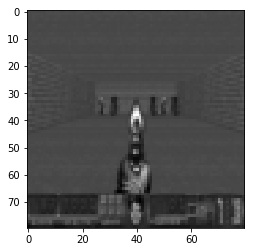

In [6]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [7]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [8]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [9]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [10]:
ready_conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='ready_conv0')

ready_conv1 = Conv2DLayer(batch_norm(ready_conv0),64,filter_size=(4,4),stride=(2,2),name='ready_conv1')

ready_dense = DenseLayer(batch_norm(ready_conv1),512,name='ready_dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [11]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.utils.persistence import save,load
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [12]:
from agentnet.target_network import TargetNetwork

def add(filename, n_actions):
    ready_qvalues_layer = DenseLayer(ready_dense,n_actions,nonlinearity=None,name='ready_qval')
    load(ready_qvalues_layer, "dist_weights/{}".format(filename))
    qvalues_right.append(TargetNetwork(ready_qvalues_layer).output_layers)

In [13]:
qvalues_right = []
#add('DoomBasic-v0.pcl', 4)
#add('DoomCorridor-v0.pcl', 7)
add('DoomDefendLine-v0.pcl', n_actions)
add('DoomBasic-v0.pcl', n_actions)
add('DoomCorridor-v0.pcl', n_actions)
#add('DoomBasic-v0.pcl')
#add('DoomCorridor-v0.pcl')
targetnet = TargetNetwork(qvalues_layer)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [12]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_right[0], qvalues_right[1], qvalues_right[2]),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 09:39:08,255] Making new env: ppaquette/DoomDefendLine-v0


In [15]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,info_log  = pool.interact(7)


print(info_log[0], action_log[0])
print(reward_log[0])

({'AMMO5': 0, 'AMMO9': 0, 'ALTATTACK_READY': 1, 'ARMOR': 0, 'AMMO3': 0, 'AMMO2': 88, 'LEVEL': 3, 'ON_GROUND': 1, 'skip.stepcount': 5, 'AMMO8': 0, 'AMMO6': 0, 'AMMO1': 0, 'HEALTH': 100, 'ATTACK_READY': 1, 'SELECTED_WEAPON': 2, 'AMMO7': 0, 'DEAD': 0, 'SECRETCOUNT': 0, 'AMMO4': 88, 'KILLCOUNT': 0, 'FRAGCOUNT': 0, 'TOTAL_REWARD': 0.0, 'AMMO0': 0, 'ITEMCOUNT': 0, 'SELECTED_WEAPON_AMMO': 88},) [2 2 3 2 2 1 0]
[ 0.  0.  0.  0.  0.  0.  0.]
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 87.2 ms


In [16]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [17]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [18]:
from agentnet.learning import qlearning
from lasagne.nonlinearities import softmax
from lasagne.objectives import squared_error
import numpy as np
def my_softmax(x):
    e_x = theano.tensor.exp(x - x.max(axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [19]:
import theano.tensor as T

tau = 1

softmax_T = [my_softmax(seq[idx] * T.exp(tau ** -1)) for idx in range(1, len(seq))]

In [20]:
import theano
from lasagne.objectives import squared_error
train_steps = []
for idx in range(3):
    #elwise_loss = softmax_T[idx] * np.log(softmax_T[idx] / softmax_S)
    #elwise_loss = squared_error(seq[idx + 1], seq[0])
    #best_pos = T.argmax(seq[idx + 1])
    #elwise_loss = -T.log(seq[0][best_pos])
    elwise_loss = softmax_T[idx] * np.log(seq[0])
    loss = elwise_loss.sum() / replay.is_alive.sum()
    updates = lasagne.updates.adam(loss,weights)
    train_steps.append(theano.function([],loss,updates=updates))

# Training loop

In [21]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-27 09:40:26,949] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:40:26,958] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 09:40:27,208] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.26011.video000000.mp4


Episode finished after 153 timesteps with reward=8.0


[2017-06-27 09:40:30,289] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.26011.video000001.mp4


Episode finished after 114 timesteps with reward=8.0
Episode finished after 41 timesteps with reward=1.0
Episode finished after 69 timesteps with reward=2.0
Episode finished after 73 timesteps with reward=3.0
Episode finished after 72 timesteps with reward=3.0
Episode finished after 100 timesteps with reward=4.0


[2017-06-27 09:40:38,814] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.26011.video000008.mp4


Episode finished after 85 timesteps with reward=3.0
Episode finished after 92 timesteps with reward=4.0


[2017-06-27 09:40:41,553] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 38 timesteps with reward=1.0


In [22]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [23]:
distilled_path = "distilled/default_amn.pcl"

In [24]:
from tqdm import trange
from agentnet.utils.persistence import save,load
#the loop may take eons to finish.
#consider interrupting early.
best_reward = -1000
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    loss = train_steps[i % 3]
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
        #if np.mean(rewards[epoch_counter]) > best_reward:
        #    best_reward = np.mean(rewards[epoch_counter])
        #    save(action_layer, distilled_path)
        
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:01<04:17,  7.72it/s]

iter=10	epsilon=0.954	reward/step=0.07273


  1%|          | 21/2000 [00:02<04:09,  7.94it/s]

iter=20	epsilon=0.910	reward/step=0.05714


  2%|▏         | 31/2000 [00:03<04:18,  7.60it/s]

iter=30	epsilon=0.868	reward/step=0.05806


  2%|▏         | 41/2000 [00:05<04:30,  7.25it/s]

iter=40	epsilon=0.828	reward/step=0.06098


  2%|▏         | 49/2000 [00:06<04:26,  7.33it/s][2017-06-27 09:40:48,177] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:40:48,183] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.06471
Episode finished after 108 timesteps with reward=4.0
Episode finished after 125 timesteps with reward=9.0
Episode finished after 96 timesteps with reward=7.0
Episode finished after 125 timesteps with reward=7.0


[2017-06-27 09:40:55,702] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  3%|▎         | 51/2000 [00:14<55:54,  1.72s/it]  

Episode finished after 85 timesteps with reward=3.0


  3%|▎         | 61/2000 [00:15<06:00,  5.37it/s]

iter=60	epsilon=0.754	reward/step=0.06066


  4%|▎         | 71/2000 [00:17<04:47,  6.70it/s]

iter=70	epsilon=0.719	reward/step=0.05915


  4%|▍         | 81/2000 [00:18<04:50,  6.62it/s]

iter=80	epsilon=0.687	reward/step=0.05432


  5%|▍         | 91/2000 [00:20<04:59,  6.38it/s]

iter=90	epsilon=0.656	reward/step=0.05604


  5%|▍         | 99/2000 [00:21<05:02,  6.28it/s][2017-06-27 09:41:03,240] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:41:03,245] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.05446
Episode finished after 54 timesteps with reward=0.0
Episode finished after 121 timesteps with reward=7.0
Episode finished after 96 timesteps with reward=6.0
Episode finished after 134 timesteps with reward=10.0


[2017-06-27 09:41:09,899] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 101/2000 [00:28<49:19,  1.56s/it]  

Episode finished after 72 timesteps with reward=5.0


  6%|▌         | 111/2000 [00:30<06:10,  5.10it/s]

iter=110	epsilon=0.598	reward/step=0.05405


  6%|▌         | 121/2000 [00:31<05:00,  6.25it/s]

iter=120	epsilon=0.571	reward/step=0.05372


  7%|▋         | 131/2000 [00:33<05:04,  6.13it/s]

iter=130	epsilon=0.546	reward/step=0.05496


  7%|▋         | 141/2000 [00:34<05:06,  6.06it/s]

iter=140	epsilon=0.522	reward/step=0.05532


  7%|▋         | 149/2000 [00:36<05:15,  5.86it/s][2017-06-27 09:41:18,021] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:41:18,025] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.05298
Episode finished after 45 timesteps with reward=1.0
Episode finished after 118 timesteps with reward=6.0
Episode finished after 57 timesteps with reward=3.0
Episode finished after 71 timesteps with reward=4.0


[2017-06-27 09:41:24,286] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 151/2000 [00:42<45:54,  1.49s/it]  

Episode finished after 165 timesteps with reward=11.0


  8%|▊         | 161/2000 [00:44<06:27,  4.75it/s]

iter=160	epsilon=0.477	reward/step=0.05217


  9%|▊         | 171/2000 [00:46<05:30,  5.53it/s]

iter=170	epsilon=0.456	reward/step=0.05146


  9%|▉         | 181/2000 [00:48<05:30,  5.51it/s]

iter=180	epsilon=0.436	reward/step=0.05083


 10%|▉         | 191/2000 [00:50<05:52,  5.13it/s]

iter=190	epsilon=0.417	reward/step=0.05131


 10%|▉         | 199/2000 [00:51<05:44,  5.24it/s][2017-06-27 09:41:33,491] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:41:33,496] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.05075
Episode finished after 72 timesteps with reward=2.0
Episode finished after 56 timesteps with reward=0.0
Episode finished after 124 timesteps with reward=8.0
Episode finished after 44 timesteps with reward=1.0


[2017-06-27 09:41:39,732] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [00:58<1:01:58,  2.07s/it]

Episode finished after 165 timesteps with reward=8.0


 11%|█         | 211/2000 [01:00<06:54,  4.32it/s]  

iter=210	epsilon=0.382	reward/step=0.05024


 11%|█         | 220/2000 [01:02<06:16,  4.73it/s]

iter=220	epsilon=0.366	reward/step=0.04977


 12%|█▏        | 230/2000 [01:04<06:25,  4.60it/s]

iter=230	epsilon=0.351	reward/step=0.04935


 12%|█▏        | 240/2000 [01:06<06:31,  4.49it/s]

iter=240	epsilon=0.336	reward/step=0.04813


 12%|█▏        | 249/2000 [01:08<06:43,  4.34it/s][2017-06-27 09:41:50,388] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:41:50,396] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.04741
Episode finished after 58 timesteps with reward=2.0
Episode finished after 35 timesteps with reward=0.0
Episode finished after 93 timesteps with reward=5.0
Episode finished after 122 timesteps with reward=6.0


[2017-06-27 09:41:55,309] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:13<50:01,  1.71s/it]

Episode finished after 47 timesteps with reward=2.0


 13%|█▎        | 260/2000 [01:16<07:59,  3.63it/s]

iter=260	epsilon=0.309	reward/step=0.04789


 14%|█▎        | 270/2000 [01:18<06:51,  4.20it/s]

iter=270	epsilon=0.296	reward/step=0.04760


 14%|█▍        | 280/2000 [01:20<07:11,  3.99it/s]

iter=280	epsilon=0.284	reward/step=0.04875


 14%|█▍        | 290/2000 [01:23<07:05,  4.02it/s]

iter=290	epsilon=0.273	reward/step=0.04880


 15%|█▍        | 299/2000 [01:25<06:57,  4.08it/s][2017-06-27 09:42:07,324] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:42:07,328] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.04767
Episode finished after 207 timesteps with reward=13.0
Episode finished after 80 timesteps with reward=4.0
Episode finished after 38 timesteps with reward=1.0
Episode finished after 60 timesteps with reward=2.0


[2017-06-27 09:42:14,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [01:32<1:04:57,  2.29s/it]

Episode finished after 117 timesteps with reward=6.0


 16%|█▌        | 310/2000 [01:34<08:25,  3.34it/s]  

iter=310	epsilon=0.252	reward/step=0.04567


 16%|█▌        | 320/2000 [01:37<06:53,  4.06it/s]

iter=320	epsilon=0.242	reward/step=0.04600


 16%|█▋        | 330/2000 [01:39<06:43,  4.14it/s]

iter=330	epsilon=0.232	reward/step=0.04467


 17%|█▋        | 340/2000 [01:42<06:35,  4.20it/s]

iter=340	epsilon=0.224	reward/step=0.04400


 17%|█▋        | 349/2000 [01:44<06:44,  4.08it/s][2017-06-27 09:42:26,264] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:42:26,269] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.04300
Episode finished after 83 timesteps with reward=4.0
Episode finished after 52 timesteps with reward=2.0
Episode finished after 113 timesteps with reward=6.0
Episode finished after 108 timesteps with reward=6.0


[2017-06-27 09:42:31,794] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [01:50<52:28,  1.91s/it]

Episode finished after 47 timesteps with reward=1.0


 18%|█▊        | 360/2000 [01:52<07:51,  3.48it/s]

iter=360	epsilon=0.207	reward/step=0.04333


 18%|█▊        | 370/2000 [01:55<06:35,  4.12it/s]

iter=370	epsilon=0.199	reward/step=0.04300


 19%|█▉        | 380/2000 [01:57<06:32,  4.12it/s]

iter=380	epsilon=0.192	reward/step=0.04267


 20%|█▉        | 390/2000 [01:59<06:26,  4.17it/s]

iter=390	epsilon=0.185	reward/step=0.04200


 20%|█▉        | 399/2000 [02:02<06:29,  4.11it/s][2017-06-27 09:42:43,893] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:42:43,897] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.04167
Episode finished after 79 timesteps with reward=5.0
Episode finished after 39 timesteps with reward=0.0
Episode finished after 110 timesteps with reward=6.0
Episode finished after 77 timesteps with reward=4.0


[2017-06-27 09:42:49,234] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [02:07<49:25,  1.85s/it]

Episode finished after 90 timesteps with reward=5.0


 20%|██        | 410/2000 [02:10<07:32,  3.51it/s]

iter=410	epsilon=0.172	reward/step=0.04167


 21%|██        | 420/2000 [02:12<06:23,  4.12it/s]

iter=420	epsilon=0.166	reward/step=0.04100


 22%|██▏       | 430/2000 [02:14<06:35,  3.97it/s]

iter=430	epsilon=0.161	reward/step=0.04133


 22%|██▏       | 440/2000 [02:17<06:16,  4.14it/s]

iter=440	epsilon=0.155	reward/step=0.04067


 22%|██▏       | 449/2000 [02:19<06:17,  4.11it/s][2017-06-27 09:43:01,413] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:43:01,418] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.04100
Episode finished after 61 timesteps with reward=3.0
Episode finished after 55 timesteps with reward=0.0
Episode finished after 49 timesteps with reward=1.0
Episode finished after 64 timesteps with reward=4.0


[2017-06-27 09:43:05,612] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [02:24<38:58,  1.51s/it]

Episode finished after 78 timesteps with reward=4.0


 23%|██▎       | 460/2000 [02:26<07:03,  3.64it/s]

iter=460	epsilon=0.145	reward/step=0.04100


 24%|██▎       | 470/2000 [02:28<06:10,  4.13it/s]

iter=470	epsilon=0.141	reward/step=0.04133


 24%|██▍       | 480/2000 [02:31<06:02,  4.19it/s]

iter=480	epsilon=0.136	reward/step=0.04033


 24%|██▍       | 490/2000 [02:33<06:02,  4.17it/s]

iter=490	epsilon=0.132	reward/step=0.03900


 25%|██▍       | 499/2000 [02:35<06:02,  4.15it/s][2017-06-27 09:43:17,620] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:43:17,625] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.03967
Episode finished after 74 timesteps with reward=4.0
Episode finished after 57 timesteps with reward=1.0
Episode finished after 74 timesteps with reward=3.0
Episode finished after 61 timesteps with reward=2.0


[2017-06-27 09:43:21,812] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [02:40<37:33,  1.50s/it]

Episode finished after 41 timesteps with reward=0.0


 26%|██▌       | 510/2000 [02:42<06:57,  3.57it/s]

iter=510	epsilon=0.124	reward/step=0.04000


 26%|██▌       | 520/2000 [02:45<05:55,  4.16it/s]

iter=520	epsilon=0.121	reward/step=0.04033


 26%|██▋       | 530/2000 [02:47<05:49,  4.20it/s]

iter=530	epsilon=0.117	reward/step=0.03900


 27%|██▋       | 540/2000 [02:49<05:44,  4.24it/s]

iter=540	epsilon=0.114	reward/step=0.03867


 27%|██▋       | 549/2000 [02:51<05:46,  4.19it/s][2017-06-27 09:43:33,857] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:43:33,861] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.03867
Episode finished after 37 timesteps with reward=1.0
Episode finished after 123 timesteps with reward=7.0
Episode finished after 46 timesteps with reward=0.0
Episode finished after 186 timesteps with reward=12.0


[2017-06-27 09:43:39,795] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [02:58<48:55,  2.02s/it]

Episode finished after 43 timesteps with reward=0.0


 28%|██▊       | 560/2000 [03:00<07:01,  3.42it/s]

iter=560	epsilon=0.108	reward/step=0.03867


 28%|██▊       | 570/2000 [03:03<05:41,  4.18it/s]

iter=570	epsilon=0.105	reward/step=0.03800


 29%|██▉       | 580/2000 [03:05<05:47,  4.09it/s]

iter=580	epsilon=0.102	reward/step=0.03767


 30%|██▉       | 590/2000 [03:07<05:36,  4.20it/s]

iter=590	epsilon=0.100	reward/step=0.03633


 30%|██▉       | 599/2000 [03:10<05:39,  4.13it/s][2017-06-27 09:43:51,911] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:43:51,916] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.03767
Episode finished after 75 timesteps with reward=4.0
Episode finished after 61 timesteps with reward=4.0
Episode finished after 87 timesteps with reward=5.0
Episode finished after 99 timesteps with reward=4.0


[2017-06-27 09:43:58,124] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [03:16<49:18,  2.11s/it]

Episode finished after 143 timesteps with reward=9.0


 30%|███       | 610/2000 [03:18<06:49,  3.40it/s]

iter=610	epsilon=0.095	reward/step=0.03933


 31%|███       | 620/2000 [03:21<05:39,  4.06it/s]

iter=620	epsilon=0.093	reward/step=0.03900


 32%|███▏      | 630/2000 [03:23<05:38,  4.04it/s]

iter=630	epsilon=0.091	reward/step=0.03967


 32%|███▏      | 640/2000 [03:26<05:29,  4.13it/s]

iter=640	epsilon=0.089	reward/step=0.03967


 32%|███▏      | 649/2000 [03:28<05:33,  4.05it/s][2017-06-27 09:44:10,357] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:44:10,362] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.03967
Episode finished after 101 timesteps with reward=5.0
Episode finished after 112 timesteps with reward=5.0
Episode finished after 87 timesteps with reward=5.0
Episode finished after 85 timesteps with reward=4.0


[2017-06-27 09:44:16,154] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [03:34<44:47,  1.99s/it]

Episode finished after 46 timesteps with reward=1.0


 33%|███▎      | 660/2000 [03:37<06:44,  3.32it/s]

iter=660	epsilon=0.085	reward/step=0.04033


 34%|███▎      | 670/2000 [03:39<05:22,  4.12it/s]

iter=670	epsilon=0.083	reward/step=0.04000


 34%|███▍      | 680/2000 [03:41<05:23,  4.09it/s]

iter=680	epsilon=0.082	reward/step=0.04133


 34%|███▍      | 690/2000 [03:44<05:19,  4.10it/s]

iter=690	epsilon=0.080	reward/step=0.04133


 35%|███▍      | 699/2000 [03:46<05:14,  4.13it/s][2017-06-27 09:44:28,423] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:44:28,427] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.04200
Episode finished after 87 timesteps with reward=3.0
Episode finished after 124 timesteps with reward=9.0
Episode finished after 57 timesteps with reward=1.0
Episode finished after 84 timesteps with reward=4.0


[2017-06-27 09:44:33,818] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [03:52<40:27,  1.87s/it]

Episode finished after 39 timesteps with reward=0.0


 36%|███▌      | 710/2000 [03:54<06:23,  3.37it/s]

iter=710	epsilon=0.077	reward/step=0.04333


 36%|███▌      | 720/2000 [03:57<05:18,  4.02it/s]

iter=720	epsilon=0.076	reward/step=0.04300


 36%|███▋      | 730/2000 [03:59<05:03,  4.18it/s]

iter=730	epsilon=0.075	reward/step=0.04133


 37%|███▋      | 740/2000 [04:01<05:02,  4.17it/s]

iter=740	epsilon=0.073	reward/step=0.04167


 37%|███▋      | 749/2000 [04:04<05:09,  4.04it/s][2017-06-27 09:44:46,032] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:44:46,036] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.04233
Episode finished after 79 timesteps with reward=4.0
Episode finished after 97 timesteps with reward=5.0
Episode finished after 87 timesteps with reward=3.0
Episode finished after 85 timesteps with reward=4.0


[2017-06-27 09:44:51,555] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [04:09<39:54,  1.92s/it]

Episode finished after 55 timesteps with reward=2.0


 38%|███▊      | 760/2000 [04:12<05:58,  3.46it/s]

iter=760	epsilon=0.071	reward/step=0.04267


 38%|███▊      | 770/2000 [04:14<04:57,  4.13it/s]

iter=770	epsilon=0.070	reward/step=0.04300


 39%|███▉      | 780/2000 [04:17<05:03,  4.02it/s]

iter=780	epsilon=0.069	reward/step=0.04467


 40%|███▉      | 790/2000 [04:19<04:53,  4.13it/s]

iter=790	epsilon=0.068	reward/step=0.04567


 40%|███▉      | 799/2000 [04:21<04:49,  4.15it/s][2017-06-27 09:45:03,691] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:45:03,696] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.04433
Episode finished after 33 timesteps with reward=-1.0
Episode finished after 67 timesteps with reward=1.0
Episode finished after 58 timesteps with reward=3.0
Episode finished after 130 timesteps with reward=7.0


[2017-06-27 09:45:08,063] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [04:26<31:06,  1.56s/it]

Episode finished after 34 timesteps with reward=0.0


 40%|████      | 810/2000 [04:28<05:28,  3.62it/s]

iter=810	epsilon=0.067	reward/step=0.04433


 41%|████      | 820/2000 [04:31<04:46,  4.12it/s]

iter=820	epsilon=0.066	reward/step=0.04433


 42%|████▏     | 830/2000 [04:33<04:39,  4.19it/s]

iter=830	epsilon=0.065	reward/step=0.04567


 42%|████▏     | 840/2000 [04:36<04:41,  4.12it/s]

iter=840	epsilon=0.064	reward/step=0.04633


 42%|████▏     | 849/2000 [04:38<04:34,  4.19it/s][2017-06-27 09:45:20,076] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:45:20,080] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.04567
Episode finished after 130 timesteps with reward=8.0
Episode finished after 60 timesteps with reward=2.0
Episode finished after 85 timesteps with reward=4.0
Episode finished after 62 timesteps with reward=2.0


[2017-06-27 09:45:25,431] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [04:43<35:32,  1.85s/it]

Episode finished after 58 timesteps with reward=0.0


 43%|████▎     | 860/2000 [04:46<05:24,  3.52it/s]

iter=860	epsilon=0.063	reward/step=0.04567


 44%|████▎     | 870/2000 [04:48<04:43,  3.98it/s]

iter=870	epsilon=0.062	reward/step=0.04767


 44%|████▍     | 880/2000 [04:51<04:27,  4.19it/s]

iter=880	epsilon=0.062	reward/step=0.04767


 44%|████▍     | 890/2000 [04:53<04:26,  4.17it/s]

iter=890	epsilon=0.061	reward/step=0.04967


 45%|████▍     | 899/2000 [04:55<04:31,  4.05it/s][2017-06-27 09:45:37,595] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:45:37,599] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.04867
Episode finished after 105 timesteps with reward=6.0
Episode finished after 100 timesteps with reward=5.0
Episode finished after 104 timesteps with reward=6.0
Episode finished after 43 timesteps with reward=0.0


[2017-06-27 09:45:44,018] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [05:02<39:50,  2.17s/it]

Episode finished after 128 timesteps with reward=6.0


 46%|████▌     | 910/2000 [05:04<05:19,  3.41it/s]

iter=910	epsilon=0.060	reward/step=0.04633


 46%|████▌     | 920/2000 [05:07<04:23,  4.10it/s]

iter=920	epsilon=0.060	reward/step=0.04633


 46%|████▋     | 930/2000 [05:09<04:18,  4.13it/s]

iter=930	epsilon=0.059	reward/step=0.04600


 47%|████▋     | 940/2000 [05:12<04:10,  4.24it/s]

iter=940	epsilon=0.059	reward/step=0.04533


 47%|████▋     | 949/2000 [05:14<04:18,  4.06it/s][2017-06-27 09:45:56,081] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:45:56,085] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.04600
Episode finished after 38 timesteps with reward=2.0
Episode finished after 78 timesteps with reward=3.0
Episode finished after 140 timesteps with reward=6.0
Episode finished after 38 timesteps with reward=1.0


[2017-06-27 09:46:00,551] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [05:18<27:50,  1.59s/it]

Episode finished after 33 timesteps with reward=-1.0


 48%|████▊     | 960/2000 [05:21<04:50,  3.58it/s]

iter=960	epsilon=0.058	reward/step=0.04467


 48%|████▊     | 970/2000 [05:23<04:12,  4.08it/s]

iter=970	epsilon=0.057	reward/step=0.04600


 49%|████▉     | 980/2000 [05:26<04:06,  4.14it/s]

iter=980	epsilon=0.057	reward/step=0.04600


 50%|████▉     | 990/2000 [05:28<04:05,  4.11it/s]

iter=990	epsilon=0.057	reward/step=0.04600


 50%|████▉     | 999/2000 [05:30<04:02,  4.13it/s][2017-06-27 09:46:12,637] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:46:12,642] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.04633
Episode finished after 84 timesteps with reward=5.0
Episode finished after 141 timesteps with reward=7.0
Episode finished after 50 timesteps with reward=1.0
Episode finished after 74 timesteps with reward=2.0


[2017-06-27 09:46:18,013] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [05:36<31:05,  1.87s/it]

Episode finished after 48 timesteps with reward=2.0


 50%|█████     | 1010/2000 [05:38<04:43,  3.49it/s]

iter=1010	epsilon=0.056	reward/step=0.04567


 51%|█████     | 1020/2000 [05:41<03:57,  4.13it/s]

iter=1020	epsilon=0.056	reward/step=0.04633


 52%|█████▏    | 1030/2000 [05:43<03:51,  4.19it/s]

iter=1030	epsilon=0.056	reward/step=0.04633


 52%|█████▏    | 1040/2000 [05:46<03:48,  4.21it/s]

iter=1040	epsilon=0.055	reward/step=0.04533


 52%|█████▏    | 1049/2000 [05:48<03:50,  4.12it/s][2017-06-27 09:46:30,085] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:46:30,090] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.04600
Episode finished after 51 timesteps with reward=1.0
Episode finished after 70 timesteps with reward=2.0
Episode finished after 98 timesteps with reward=4.0
Episode finished after 82 timesteps with reward=2.0


[2017-06-27 09:46:35,035] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [05:53<27:21,  1.73s/it]

Episode finished after 66 timesteps with reward=2.0


 53%|█████▎    | 1060/2000 [05:55<04:25,  3.54it/s]

iter=1060	epsilon=0.055	reward/step=0.04567


 54%|█████▎    | 1070/2000 [05:58<03:46,  4.11it/s]

iter=1070	epsilon=0.055	reward/step=0.04533


 54%|█████▍    | 1080/2000 [06:00<03:40,  4.17it/s]

iter=1080	epsilon=0.054	reward/step=0.04433


 55%|█████▍    | 1090/2000 [06:03<03:46,  4.01it/s]

iter=1090	epsilon=0.054	reward/step=0.04467


 55%|█████▍    | 1099/2000 [06:05<03:36,  4.16it/s][2017-06-27 09:46:47,122] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:46:47,126] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.04533
Episode finished after 101 timesteps with reward=8.0
Episode finished after 161 timesteps with reward=11.0
Episode finished after 85 timesteps with reward=5.0
Episode finished after 92 timesteps with reward=6.0


[2017-06-27 09:46:53,961] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [06:12<34:24,  2.29s/it]

Episode finished after 66 timesteps with reward=3.0


 56%|█████▌    | 1110/2000 [06:14<04:30,  3.29it/s]

iter=1110	epsilon=0.054	reward/step=0.04500


 56%|█████▌    | 1120/2000 [06:17<03:35,  4.08it/s]

iter=1120	epsilon=0.054	reward/step=0.04567


 56%|█████▋    | 1130/2000 [06:19<03:31,  4.11it/s]

iter=1130	epsilon=0.053	reward/step=0.04567


 57%|█████▋    | 1140/2000 [06:22<03:28,  4.13it/s]

iter=1140	epsilon=0.053	reward/step=0.04600


 57%|█████▋    | 1149/2000 [06:24<03:24,  4.15it/s][2017-06-27 09:47:06,117] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:47:06,121] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.04600
Episode finished after 118 timesteps with reward=6.0
Episode finished after 115 timesteps with reward=6.0
Episode finished after 75 timesteps with reward=4.0
Episode finished after 79 timesteps with reward=6.0


[2017-06-27 09:47:12,142] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [06:30<29:07,  2.06s/it]

Episode finished after 51 timesteps with reward=3.0


 58%|█████▊    | 1160/2000 [06:32<04:03,  3.44it/s]

iter=1160	epsilon=0.053	reward/step=0.04433


 58%|█████▊    | 1170/2000 [06:35<03:18,  4.18it/s]

iter=1170	epsilon=0.053	reward/step=0.04333


 59%|█████▉    | 1180/2000 [06:37<03:18,  4.12it/s]

iter=1180	epsilon=0.053	reward/step=0.04333


 60%|█████▉    | 1190/2000 [06:40<03:18,  4.07it/s]

iter=1190	epsilon=0.052	reward/step=0.04267


 60%|█████▉    | 1199/2000 [06:42<03:08,  4.26it/s][2017-06-27 09:47:24,144] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:47:24,148] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.04233
Episode finished after 65 timesteps with reward=4.0
Episode finished after 86 timesteps with reward=3.0
Episode finished after 89 timesteps with reward=5.0
Episode finished after 40 timesteps with reward=0.0


[2017-06-27 09:47:28,836] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [06:47<21:58,  1.65s/it]

Episode finished after 66 timesteps with reward=3.0


 60%|██████    | 1210/2000 [06:49<03:39,  3.60it/s]

iter=1210	epsilon=0.052	reward/step=0.04367


 61%|██████    | 1220/2000 [06:52<03:07,  4.15it/s]

iter=1220	epsilon=0.052	reward/step=0.04367


 62%|██████▏   | 1230/2000 [06:54<03:06,  4.12it/s]

iter=1230	epsilon=0.052	reward/step=0.04433


 62%|██████▏   | 1240/2000 [06:56<03:00,  4.21it/s]

iter=1240	epsilon=0.052	reward/step=0.04467


 62%|██████▏   | 1249/2000 [06:59<03:01,  4.14it/s][2017-06-27 09:47:40,875] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:47:40,879] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.04433
Episode finished after 100 timesteps with reward=5.0
Episode finished after 51 timesteps with reward=0.0
Episode finished after 51 timesteps with reward=2.0
Episode finished after 74 timesteps with reward=5.0


[2017-06-27 09:47:46,118] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [07:04<22:45,  1.82s/it]

Episode finished after 113 timesteps with reward=6.0


 63%|██████▎   | 1260/2000 [07:06<03:30,  3.52it/s]

iter=1260	epsilon=0.052	reward/step=0.04367


 64%|██████▎   | 1270/2000 [07:09<02:54,  4.17it/s]

iter=1270	epsilon=0.052	reward/step=0.04333


 64%|██████▍   | 1280/2000 [07:11<02:56,  4.09it/s]

iter=1280	epsilon=0.052	reward/step=0.04333


 64%|██████▍   | 1290/2000 [07:14<02:49,  4.18it/s]

iter=1290	epsilon=0.052	reward/step=0.04333


 65%|██████▍   | 1299/2000 [07:16<02:47,  4.19it/s][2017-06-27 09:47:58,141] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:47:58,146] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.04233
Episode finished after 102 timesteps with reward=5.0
Episode finished after 64 timesteps with reward=2.0
Episode finished after 42 timesteps with reward=1.0
Episode finished after 102 timesteps with reward=5.0


[2017-06-27 09:48:03,458] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [07:21<21:29,  1.84s/it]

Episode finished after 84 timesteps with reward=3.0


 66%|██████▌   | 1310/2000 [07:24<03:14,  3.54it/s]

iter=1310	epsilon=0.051	reward/step=0.04133


 66%|██████▌   | 1320/2000 [07:26<02:43,  4.16it/s]

iter=1320	epsilon=0.051	reward/step=0.04133


 66%|██████▋   | 1330/2000 [07:29<02:42,  4.13it/s]

iter=1330	epsilon=0.051	reward/step=0.04200


 67%|██████▋   | 1340/2000 [07:31<02:40,  4.12it/s]

iter=1340	epsilon=0.051	reward/step=0.04233


 67%|██████▋   | 1349/2000 [07:33<02:36,  4.16it/s][2017-06-27 09:48:15,489] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:48:15,493] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.04167
Episode finished after 72 timesteps with reward=3.0
Episode finished after 67 timesteps with reward=3.0
Episode finished after 82 timesteps with reward=4.0
Episode finished after 64 timesteps with reward=3.0


[2017-06-27 09:48:19,856] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [07:38<16:49,  1.55s/it]

Episode finished after 36 timesteps with reward=-1.0


 68%|██████▊   | 1360/2000 [07:40<02:56,  3.62it/s]

iter=1360	epsilon=0.051	reward/step=0.04133


 68%|██████▊   | 1370/2000 [07:43<02:33,  4.11it/s]

iter=1370	epsilon=0.051	reward/step=0.04100


 69%|██████▉   | 1380/2000 [07:45<02:29,  4.14it/s]

iter=1380	epsilon=0.051	reward/step=0.04267


 70%|██████▉   | 1390/2000 [07:47<02:25,  4.18it/s]

iter=1390	epsilon=0.051	reward/step=0.04200


 70%|██████▉   | 1399/2000 [07:50<02:23,  4.20it/s][2017-06-27 09:48:31,905] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:48:31,910] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.04200
Episode finished after 77 timesteps with reward=4.0
Episode finished after 72 timesteps with reward=2.0
Episode finished after 36 timesteps with reward=0.0
Episode finished after 127 timesteps with reward=8.0


[2017-06-27 09:48:37,530] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [07:55<19:19,  1.93s/it]

Episode finished after 109 timesteps with reward=7.0


 70%|███████   | 1410/2000 [07:58<02:49,  3.48it/s]

iter=1410	epsilon=0.051	reward/step=0.04200


 71%|███████   | 1420/2000 [08:00<02:22,  4.06it/s]

iter=1420	epsilon=0.051	reward/step=0.04200


 72%|███████▏  | 1430/2000 [08:03<02:17,  4.14it/s]

iter=1430	epsilon=0.051	reward/step=0.04200


 72%|███████▏  | 1440/2000 [08:05<02:13,  4.19it/s]

iter=1440	epsilon=0.051	reward/step=0.04200


 72%|███████▏  | 1449/2000 [08:07<02:11,  4.19it/s][2017-06-27 09:48:49,563] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:48:49,567] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.04367
Episode finished after 67 timesteps with reward=2.0
Episode finished after 99 timesteps with reward=5.0
Episode finished after 107 timesteps with reward=7.0
Episode finished after 82 timesteps with reward=3.0


[2017-06-27 09:48:55,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [08:13<17:33,  1.92s/it]

Episode finished after 52 timesteps with reward=1.0


 73%|███████▎  | 1460/2000 [08:15<02:35,  3.48it/s]

iter=1460	epsilon=0.051	reward/step=0.04467


 74%|███████▎  | 1470/2000 [08:18<02:08,  4.14it/s]

iter=1470	epsilon=0.051	reward/step=0.04367


 74%|███████▍  | 1480/2000 [08:20<02:07,  4.08it/s]

iter=1480	epsilon=0.051	reward/step=0.04300


 74%|███████▍  | 1490/2000 [08:23<02:03,  4.14it/s]

iter=1490	epsilon=0.051	reward/step=0.04267


 75%|███████▍  | 1499/2000 [08:25<01:59,  4.20it/s][2017-06-27 09:49:07,207] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:49:07,212] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.04267
Episode finished after 81 timesteps with reward=2.0
Episode finished after 54 timesteps with reward=1.0
Episode finished after 34 timesteps with reward=0.0
Episode finished after 93 timesteps with reward=5.0


[2017-06-27 09:49:12,151] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [08:30<14:22,  1.72s/it]

Episode finished after 102 timesteps with reward=6.0


 76%|███████▌  | 1510/2000 [08:32<02:17,  3.57it/s]

iter=1510	epsilon=0.050	reward/step=0.04367


 76%|███████▌  | 1520/2000 [08:35<01:55,  4.16it/s]

iter=1520	epsilon=0.050	reward/step=0.04367


 76%|███████▋  | 1530/2000 [08:37<01:54,  4.11it/s]

iter=1530	epsilon=0.050	reward/step=0.04300


 77%|███████▋  | 1540/2000 [08:40<01:50,  4.16it/s]

iter=1540	epsilon=0.050	reward/step=0.04333


 77%|███████▋  | 1549/2000 [08:42<01:47,  4.18it/s][2017-06-27 09:49:24,183] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:49:24,187] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.04300
Episode finished after 46 timesteps with reward=2.0
Episode finished after 121 timesteps with reward=6.0
Episode finished after 62 timesteps with reward=2.0
Episode finished after 158 timesteps with reward=9.0


[2017-06-27 09:49:30,039] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [08:48<15:00,  2.00s/it]

Episode finished after 45 timesteps with reward=1.0


 78%|███████▊  | 1560/2000 [08:50<02:07,  3.46it/s]

iter=1560	epsilon=0.050	reward/step=0.04400


 78%|███████▊  | 1570/2000 [08:53<01:42,  4.18it/s]

iter=1570	epsilon=0.050	reward/step=0.04267


 79%|███████▉  | 1580/2000 [08:55<01:39,  4.23it/s]

iter=1580	epsilon=0.050	reward/step=0.04200


 80%|███████▉  | 1590/2000 [08:57<01:37,  4.21it/s]

iter=1590	epsilon=0.050	reward/step=0.04033


 80%|███████▉  | 1599/2000 [09:00<01:35,  4.19it/s][2017-06-27 09:49:41,969] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:49:41,974] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.04133
Episode finished after 81 timesteps with reward=3.0
Episode finished after 114 timesteps with reward=6.0
Episode finished after 78 timesteps with reward=5.0
Episode finished after 41 timesteps with reward=1.0


[2017-06-27 09:49:46,991] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [09:05<11:40,  1.75s/it]

Episode finished after 48 timesteps with reward=0.0


 80%|████████  | 1610/2000 [09:07<01:49,  3.57it/s]

iter=1610	epsilon=0.050	reward/step=0.04100


 81%|████████  | 1620/2000 [09:10<01:31,  4.17it/s]

iter=1620	epsilon=0.050	reward/step=0.04100


 82%|████████▏ | 1630/2000 [09:12<01:28,  4.18it/s]

iter=1630	epsilon=0.050	reward/step=0.04067


 82%|████████▏ | 1640/2000 [09:14<01:25,  4.20it/s]

iter=1640	epsilon=0.050	reward/step=0.04167


 82%|████████▏ | 1649/2000 [09:17<01:23,  4.21it/s][2017-06-27 09:49:58,929] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:49:58,933] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.04133
Episode finished after 87 timesteps with reward=4.0
Episode finished after 48 timesteps with reward=0.0
Episode finished after 42 timesteps with reward=1.0
Episode finished after 85 timesteps with reward=4.0


[2017-06-27 09:50:03,054] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [09:21<08:37,  1.48s/it]

Episode finished after 38 timesteps with reward=-1.0


 83%|████████▎ | 1660/2000 [09:23<01:35,  3.57it/s]

iter=1660	epsilon=0.050	reward/step=0.04167


 84%|████████▎ | 1670/2000 [09:26<01:18,  4.23it/s]

iter=1670	epsilon=0.050	reward/step=0.04167


 84%|████████▍ | 1680/2000 [09:28<01:15,  4.23it/s]

iter=1680	epsilon=0.050	reward/step=0.04033


 84%|████████▍ | 1690/2000 [09:31<01:13,  4.23it/s]

iter=1690	epsilon=0.050	reward/step=0.04000


 85%|████████▍ | 1699/2000 [09:33<01:11,  4.19it/s][2017-06-27 09:50:15,090] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:50:15,094] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.03867
Episode finished after 112 timesteps with reward=6.0
Episode finished after 58 timesteps with reward=3.0
Episode finished after 104 timesteps with reward=7.0
Episode finished after 65 timesteps with reward=3.0


[2017-06-27 09:50:21,152] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [09:39<10:19,  2.06s/it]

Episode finished after 113 timesteps with reward=5.0


 86%|████████▌ | 1710/2000 [09:41<01:24,  3.44it/s]

iter=1710	epsilon=0.050	reward/step=0.03867


 86%|████████▌ | 1720/2000 [09:44<01:07,  4.16it/s]

iter=1720	epsilon=0.050	reward/step=0.03800


 86%|████████▋ | 1730/2000 [09:46<01:04,  4.17it/s]

iter=1730	epsilon=0.050	reward/step=0.03800


 87%|████████▋ | 1740/2000 [09:49<01:04,  4.03it/s]

iter=1740	epsilon=0.050	reward/step=0.03900


 87%|████████▋ | 1749/2000 [09:51<01:00,  4.15it/s][2017-06-27 09:50:33,255] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:50:33,259] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.03833
Episode finished after 38 timesteps with reward=0.0
Episode finished after 86 timesteps with reward=4.0
Episode finished after 103 timesteps with reward=6.0
Episode finished after 74 timesteps with reward=3.0


[2017-06-27 09:50:38,898] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [09:57<08:05,  1.94s/it]

Episode finished after 114 timesteps with reward=6.0


 88%|████████▊ | 1760/2000 [09:59<01:10,  3.41it/s]

iter=1760	epsilon=0.050	reward/step=0.03767


 88%|████████▊ | 1770/2000 [10:02<00:56,  4.08it/s]

iter=1770	epsilon=0.050	reward/step=0.03900


 89%|████████▉ | 1780/2000 [10:04<00:52,  4.17it/s]

iter=1780	epsilon=0.050	reward/step=0.03833


 90%|████████▉ | 1790/2000 [10:07<00:51,  4.06it/s]

iter=1790	epsilon=0.050	reward/step=0.03833


 90%|████████▉ | 1799/2000 [10:09<00:48,  4.17it/s][2017-06-27 09:50:51,048] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:50:51,052] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.03933
Episode finished after 59 timesteps with reward=1.0
Episode finished after 45 timesteps with reward=0.0
Episode finished after 99 timesteps with reward=7.0
Episode finished after 90 timesteps with reward=5.0


[2017-06-27 09:50:56,103] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [10:14<05:52,  1.76s/it]

Episode finished after 81 timesteps with reward=4.0


 90%|█████████ | 1810/2000 [10:16<00:54,  3.47it/s]

iter=1810	epsilon=0.050	reward/step=0.03900


 91%|█████████ | 1820/2000 [10:19<00:43,  4.12it/s]

iter=1820	epsilon=0.050	reward/step=0.04000


 92%|█████████▏| 1830/2000 [10:21<00:40,  4.19it/s]

iter=1830	epsilon=0.050	reward/step=0.04100


 92%|█████████▏| 1840/2000 [10:24<00:38,  4.18it/s]

iter=1840	epsilon=0.050	reward/step=0.04033


 92%|█████████▏| 1849/2000 [10:26<00:36,  4.19it/s][2017-06-27 09:51:08,198] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:51:08,203] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.03933
Episode finished after 99 timesteps with reward=6.0
Episode finished after 37 timesteps with reward=-1.0
Episode finished after 98 timesteps with reward=4.0
Episode finished after 53 timesteps with reward=1.0


[2017-06-27 09:51:13,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [10:31<04:18,  1.72s/it]

Episode finished after 78 timesteps with reward=4.0


 93%|█████████▎| 1860/2000 [10:33<00:39,  3.54it/s]

iter=1860	epsilon=0.050	reward/step=0.03967


 94%|█████████▎| 1870/2000 [10:36<00:31,  4.10it/s]

iter=1870	epsilon=0.050	reward/step=0.04000


 94%|█████████▍| 1880/2000 [10:38<00:28,  4.16it/s]

iter=1880	epsilon=0.050	reward/step=0.04033


 94%|█████████▍| 1890/2000 [10:41<00:26,  4.15it/s]

iter=1890	epsilon=0.050	reward/step=0.04200


 95%|█████████▍| 1899/2000 [10:43<00:24,  4.18it/s][2017-06-27 09:51:25,178] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:51:25,182] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.04100
Episode finished after 58 timesteps with reward=2.0
Episode finished after 90 timesteps with reward=4.0
Episode finished after 72 timesteps with reward=3.0
Episode finished after 55 timesteps with reward=2.0


[2017-06-27 09:51:30,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [10:49<03:19,  1.99s/it]

Episode finished after 156 timesteps with reward=8.0


 96%|█████████▌| 1910/2000 [10:51<00:26,  3.42it/s]

iter=1910	epsilon=0.050	reward/step=0.04167


 96%|█████████▌| 1920/2000 [10:54<00:19,  4.09it/s]

iter=1920	epsilon=0.050	reward/step=0.04233


 96%|█████████▋| 1930/2000 [10:56<00:16,  4.21it/s]

iter=1930	epsilon=0.050	reward/step=0.04200


 97%|█████████▋| 1940/2000 [10:59<00:14,  4.18it/s]

iter=1940	epsilon=0.050	reward/step=0.04167


 97%|█████████▋| 1949/2000 [11:01<00:12,  4.18it/s][2017-06-27 09:51:43,041] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:51:43,045] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.04133
Episode finished after 74 timesteps with reward=4.0
Episode finished after 59 timesteps with reward=2.0
Episode finished after 40 timesteps with reward=1.0
Episode finished after 70 timesteps with reward=3.0


[2017-06-27 09:51:48,155] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [11:06<01:28,  1.78s/it]

Episode finished after 130 timesteps with reward=7.0


 98%|█████████▊| 1960/2000 [11:08<00:11,  3.55it/s]

iter=1960	epsilon=0.050	reward/step=0.04067


 98%|█████████▊| 1970/2000 [11:11<00:07,  4.21it/s]

iter=1970	epsilon=0.050	reward/step=0.04100


 99%|█████████▉| 1980/2000 [11:13<00:04,  4.15it/s]

iter=1980	epsilon=0.050	reward/step=0.04133


100%|█████████▉| 1990/2000 [11:16<00:02,  4.14it/s]

iter=1990	epsilon=0.050	reward/step=0.04267


100%|█████████▉| 1999/2000 [11:18<00:00,  4.20it/s][2017-06-27 09:52:00,145] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 09:52:00,149] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=0.04333
Episode finished after 68 timesteps with reward=3.0
Episode finished after 78 timesteps with reward=4.0
Episode finished after 82 timesteps with reward=5.0
Episode finished after 73 timesteps with reward=5.0


[2017-06-27 09:52:05,853] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [11:24<00:00,  1.96s/it]

Episode finished after 121 timesteps with reward=9.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

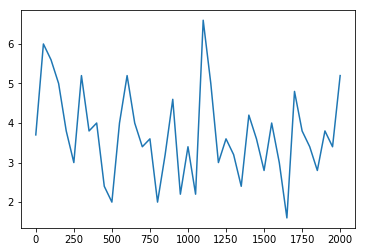

In [25]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [26]:
assert False

AssertionError: 

In [ ]:
print(distilled_path)

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer, distilled_path)

In [ ]:
import os
tmp = GAME_NAME.split('/')[1]
os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

In [ ]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
#gym.upload('/home/ubuntu/records')

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets